In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
# Download necessary NLTK data
import nltk

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load and display the data


In [2]:
# Define the path to the manually downloaded dataset
data_path = "data/data.csv"  # Update the file name if it's different

# Check if the file exists before attempting to load
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset file not found at {data_path}. Ensure the file is in the correct location.")

# Load the dataset
df= pd.read_csv(data_path)
print("Dataset loaded successfully!")

# Display the first few rows of the DataFrame
df.head()


Dataset loaded successfully!


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


# Perform EDA 

# Display class disctribution

Class distribution:
Sentiment
neutral     3124
positive    1852
negative     860
Name: count, dtype: int64

Text length stats:
count    5836.000000
mean      116.964702
std        56.318951
min         9.000000
25%        72.000000
50%       107.000000
75%       150.000000
max       315.000000
Name: text_length, dtype: float64


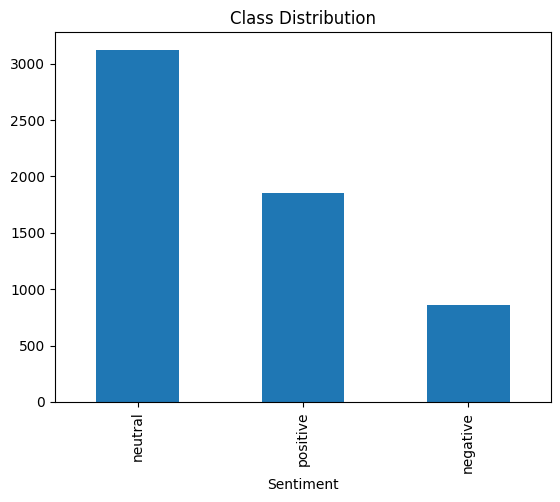

In [3]:
import matplotlib.pyplot as plt

# drop rows with missing values
df.dropna(inplace=True)
# Check for duplicates and remove them
df.drop_duplicates(inplace=True)

# Perform Exploratory Data Analysis (EDA)
def perform_eda(data):
    # Check class distribution
    print("Class distribution:")
    print(df['Sentiment'].value_counts())

    # Text length analysis
    df['text_length'] = df['Sentence'].apply(len)
    print("\nText length stats:")
    print(df['text_length'].describe())

    # Visualize class distribution
    df['Sentiment'].value_counts().plot(kind='bar', title="Class Distribution")
    plt.show()
perform_eda(df)


# Preprocess the text data
In this section we will preprocess the text data by performing the following steps:
1. Remove extra whitespaces
2. Remove HTML tags
3. Remove URLs
4. Decode HTML entities
5. Replace stock tickers (e.g., $AAPL) with a special token 'STOCK'
6. Handle currencies (e.g., $10k, €20)
7. Remove space between digits and decimal points
8. Remove space before or after a comma in large numbers
9. Ensure that numbers with units (e.g., EUR 1.6 m) have no spaces
10. Replace percentages
11. Replace months, dates, years, and hours
12. Remove special characters
13. Tokenize the text
14. Remove punctuation
15. Remove stopwords
16. Apply stemming
17. Join tokens back into text

In [4]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import html
import string
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources if not already done
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_df(text):
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Decode HTML entities
    text = html.unescape(text)

    # Replace URLs with a placeholder
    text = re.sub(r'http\S+|www\S+|https\S+', 'url', text)

    # Strip leading/trailing whitespace
    return text.strip()
    

# Apply the cleaning function to the 'Sentence' column and create a new column 'cleaned_text'
df['cleaned_text'] = df['Sentence'].apply(clean_df)
df.head(100)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Sentence,Sentiment,text_length,cleaned_text
0,The GeoSolutions technology will leverage Bene...,positive,218,The GeoSolutions technology will leverage Bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,55,"$ESI on lows, down $1.50 to $2.50 BK a real po..."
2,"For the last quarter of 2010 , Componenta 's n...",positive,193,"For the last quarter of 2010 , Componenta 's n..."
3,According to the Finnish-Russian Chamber of Co...,neutral,128,According to the Finnish-Russian Chamber of Co...
4,The Swedish buyout firm has sold its remaining...,neutral,135,The Swedish buyout firm has sold its remaining...
...,...,...,...,...
95,M-Real said there are ` no grounds ' for the r...,neutral,117,M-Real said there are ` no grounds ' for the r...
96,Lember said the matter was topical also in Est...,neutral,173,Lember said the matter was topical also in Est...
97,- Moody 's said it gave P A1 long-term senior ...,neutral,193,- Moody 's said it gave P A1 long-term senior ...
98,$TSLA recall,negative,12,$TSLA recall


# Handle imbalance
we will extract the embeddings from fibert then we will split the data to train and test and then we will handle the imbalance


In [5]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModel.from_pretrained("ProsusAI/finbert").to(device)
model.eval()  # turn off dropout etc

def get_token_level_embeddings(texts, tokenizer, model, max_length=160, batch_size=32):
    all_embeddings = []
    attention_masks = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            encodings = tokenizer(batch,
                                  padding='max_length',
                                  truncation=True,
                                  max_length=max_length,
                                  return_tensors="pt")

            input_ids = encodings['input_ids'].to(device)
            attention_mask = encodings['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state  # shape: (batch_size, max_length, 768)

            all_embeddings.append(embeddings.cpu())
            attention_masks.append(attention_mask.cpu())

    return torch.cat(all_embeddings, dim=0), torch.cat(attention_masks, dim=0)


#map the Sentiment labels to numerical values
label_mapping = {'positive': 0, 'negative': 1, 'neutral': 2}
df['label'] = df['Sentiment'].map(label_mapping)
# Prepare the texts and labels for embedding
texts = df['cleaned_text'].tolist()
labels = df['label'].tolist()

X_embeddings,attention_masks = get_token_level_embeddings(texts, tokenizer, model)
y = np.array(labels)



c:\Users\mateo\anaconda3\envs\deepL\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\mateo\anaconda3\envs\deepL\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\mateo\anaconda3\envs\deepL\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
W0616 14:57:28.391000 5196 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
c:\Users

In [6]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Split the dataset into training and testing sets
# split κανονικά
X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(
    X_embeddings, y, attention_masks, test_size=0.2, stratify=y, random_state=42
)


# Υπολογισμός class weights βάσει του training set
train_labels_np = np.array(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_np),
    y=train_labels_np
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Εκτύπωση για έλεγχο
print("Class weights:", class_weights_tensor)


# torch tensors
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(mask_train, dtype=torch.long),
    torch.tensor(y_train, dtype=torch.long)
)



Class weights: tensor([1.0506, 2.2616, 0.6226])


C:\Users\mateo\AppData\Local\Temp\ipykernel_5196\2012054859.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_train, dtype=torch.float32),
C:\Users\mateo\AppData\Local\Temp\ipykernel_5196\2012054859.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(mask_train, dtype=torch.long),


# Focal Loss

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean', task_type='binary', num_classes=None):
        """
        Unified Focal Loss class for binary, multi-class, and multi-label classification tasks.
        :param gamma: Focusing parameter, controls the strength of the modulating factor (1 - p_t)^gamma
        :param alpha: Balancing factor, can be a scalar or a tensor for class-wise weights. If None, no class balancing is used.
        :param reduction: Specifies the reduction method: 'none' | 'mean' | 'sum'
        :param task_type: Specifies the type of task: 'binary', 'multi-class', or 'multi-label'
        :param num_classes: Number of classes (only required for multi-class classification)
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.task_type = task_type
        self.num_classes = num_classes

        # Handle alpha for class balancing in multi-class tasks
        if task_type == 'multi-class' and alpha is not None and isinstance(alpha, (list, torch.Tensor)):
            assert num_classes is not None, "num_classes must be specified for multi-class classification"
            if isinstance(alpha, list):
                self.alpha = torch.Tensor(alpha)
            else:
                self.alpha = alpha

    def forward(self, inputs, targets):
        """
        Forward pass to compute the Focal Loss based on the specified task type.
        :param inputs: Predictions (logits) from the model.
                       Shape:
                         - binary/multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size, num_classes)
        :param targets: Ground truth labels.
                        Shape:
                         - binary: (batch_size,)
                         - multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size,)
        """
        if self.task_type == 'binary':
            return self.binary_focal_loss(inputs, targets)
        elif self.task_type == 'multi-class':
            return self.multi_class_focal_loss(inputs, targets)
        elif self.task_type == 'multi-label':
            return self.multi_label_focal_loss(inputs, targets)
        else:
            raise ValueError(
                f"Unsupported task_type '{self.task_type}'. Use 'binary', 'multi-class', or 'multi-label'.")

    def binary_focal_loss(self, inputs, targets):
        """ Focal loss for binary classification. """
        probs = torch.sigmoid(inputs)
        targets = targets.float()

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weighting
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_class_focal_loss(self, inputs, targets):
        """ Focal loss for multi-class classification. """
        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)

        # Convert logits to probabilities with softmax
        probs = F.softmax(inputs, dim=1)

        # One-hot encode the targets
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()

        # Compute cross-entropy for each class
        ce_loss = -targets_one_hot * torch.log(probs)

        # Compute focal weight
        p_t = torch.sum(probs * targets_one_hot, dim=1)  # p_t for each sample
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided (per-class weighting)
        if self.alpha is not None:
            alpha_t = alpha.gather(0, targets)
            ce_loss = alpha_t.unsqueeze(1) * ce_loss

        # Apply focal loss weight
        loss = focal_weight.unsqueeze(1) * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_label_focal_loss(self, inputs, targets):
        """ Focal loss for multi-label classification. """
        probs = torch.sigmoid(inputs)

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weight
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss


# Now we will train LSTM

In [8]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128, output_dim=3, num_layers=1, bidirectional=True, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0
        )
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_output_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len=1, input_dim)
        lstm_out, _ = self.lstm(x)
        last_hidden_state = lstm_out[:, -1, :]  # (batch_size, hidden_dim * num_directions)
        x = self.dropout(last_hidden_state)
        return self.fc(x)
    
def evaluate_lstm(model, val_loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for xb, mask, yb in val_loader:
            xb, mask, yb = xb.to(device), mask.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    avg_loss = total_loss / len(val_loader)
    acc = correct / total
    return avg_loss, acc

def train_lstm_model(model, train_loader, val_loader, class_weights, num_epochs=20, lr=1e-4, patience=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    criterion = FocalLoss(
        gamma=2,
        alpha=class_weights * 3,
        reduction='mean',
        task_type='multi-class',
        num_classes=3
    )

    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    val_losses = []
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for xb, mask, yb in train_loader:
            xb, mask, yb = xb.to(device), mask.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        train_acc = correct / total
        train_loss = total_loss / len(train_loader)

        # Validation
        val_loss, val_acc = evaluate_lstm(model, val_loader, criterion)
        #save losses and accuracies
        
        val_losses.append(val_loss)
        train_losses.append(train_loss)
        # Scheduler step
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Return best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model,val_losses, train_losses


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(mask_test, dtype=torch.long),
        torch.tensor(y_test, dtype=torch.long)
    ),
    batch_size=64,
    shuffle=False
)
model = LSTMClassifier()
trained_model,val_loss,train_loss= train_lstm_model(model, train_loader, val_loader, class_weights_tensor)



C:\Users\mateo\AppData\Local\Temp\ipykernel_5196\544090764.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_test, dtype=torch.float32),
C:\Users\mateo\AppData\Local\Temp\ipykernel_5196\544090764.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(mask_test, dtype=torch.long),


Epoch 1: Train Loss: 0.3394 | Train Acc: 0.6731 | Val Loss: 0.2324 | Val Acc: 0.7628
Epoch 2: Train Loss: 0.2031 | Train Acc: 0.7626 | Val Loss: 0.1663 | Val Acc: 0.7962
Epoch 3: Train Loss: 0.1610 | Train Acc: 0.7817 | Val Loss: 0.1555 | Val Acc: 0.7979
Epoch 4: Train Loss: 0.1448 | Train Acc: 0.7913 | Val Loss: 0.1487 | Val Acc: 0.7945
Epoch 5: Train Loss: 0.1353 | Train Acc: 0.8014 | Val Loss: 0.1425 | Val Acc: 0.8057
Epoch 6: Train Loss: 0.1273 | Train Acc: 0.8091 | Val Loss: 0.1482 | Val Acc: 0.8005
Epoch 7: Train Loss: 0.1196 | Train Acc: 0.8153 | Val Loss: 0.1443 | Val Acc: 0.7979
Epoch 8: Train Loss: 0.1129 | Train Acc: 0.8228 | Val Loss: 0.1444 | Val Acc: 0.8014
Early stopping triggered.


Classification Report:
              precision    recall  f1-score   support

    Positive       0.86      0.86      0.86       371
    Negative       0.50      0.88      0.64       172
     Neutral       0.94      0.74      0.83       625

    accuracy                           0.80      1168
   macro avg       0.77      0.83      0.78      1168
weighted avg       0.85      0.80      0.81      1168



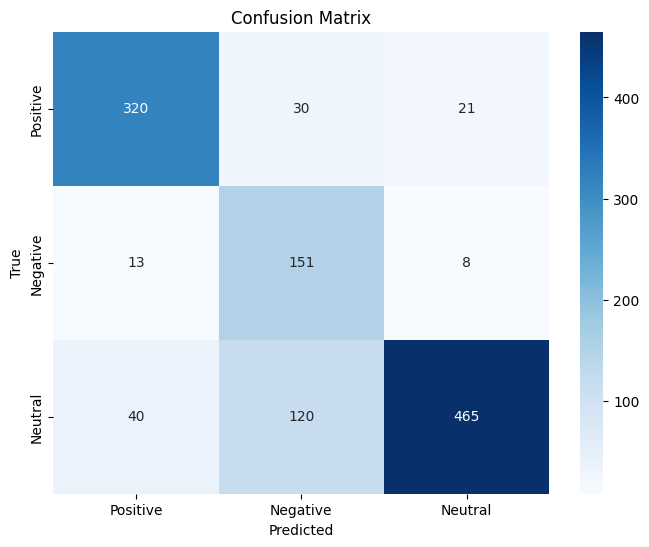

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, mask, yb in val_loader:
        xb, mask, yb = xb.to(device), mask.to(device), yb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())
# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Positive', 'Negative', 'Neutral']))
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8014
F1 Score: 0.8120
Precision: 0.8501
Recall: 0.8014


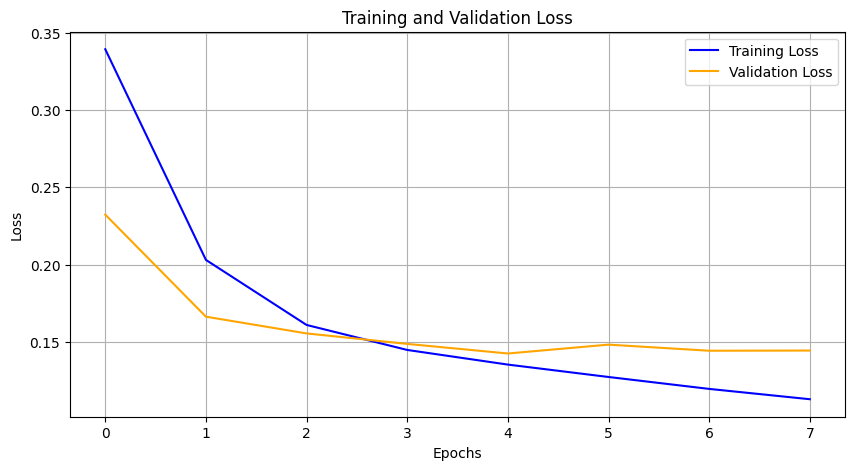

In [11]:
# plot training loss
def plot_training_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_training_loss(train_loss, val_loss)

In [12]:
# print model architecture
print(model)

LSTMClassifier(
  (lstm): LSTM(768, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)
